# An Introduction to Neural Networks: Learning the Dubins car dynamics

In this notebook, we aim to **learn the dynamics of the Dubins car using a fully connected neural network** in Python. For this, we will employ the Pytorch library, which is an optimized tensor library for deep learning using GPUs and CPUs (https://pytorch.org/). 

Let $h$ be a step size, $v$ a velocity, and a constant control $u$. The Dubins car model (in discrete time) can be described as:

\begin{equation}
x_{t+1} = f(x_t) = \begin{bmatrix}
                      x_{t, 1} + h v \sin(x_{t, 3}) \\
                      x_{t, 2} + h v \cos(x_{t, 3}) \\
                      x_{t, 3} + h u
                    \end{bmatrix}
\end{equation}

where $x_{t, 1}$ represents the $x$-position of the car at instant $t$, $x_{t, 2}$ the $y$-position, and $x_{t, 3}$ is its steering angle. Note that this dynamics is non-linear.

### 1) What we want to see

- **Understand the first sections and answer questions**: The first 6 sections contain explanations about the dataset and the construction of a simple NN. There are <span style="color: #8080ff">some questions in blue</span> that should be answered (one or two sentences are more than enough :) ) 

- **Code Section 7**: Section 7 is the main task of this exercise. It requires the construction of a larger NN, also varying training choices 

- You can do everything on your laptop, but it might be a good idea to use google colab (https://colab.research.google.com/) to get free access to a GPU

- You will send your notebook containing the results (WE WON'T RUN YOUR NOTEBOOK) as a unique jupyter notebook file (.ipynb extension). We won't open any other supplementary file

### 2) Loading required libraries

First, we load the packages we want to use. This includes Numpy for preprocessing the data, Pytorch (torch) for building and training the neural networks, and Matplotlib visualization.

In [42]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

### 3) Loading the dataset

To build our dataset, we selected the values for the parameters $h = 0.3$, $v = 5$, and $u = 2$ and generated a dataset $\mathcal{D} = \{ x_{t}, x_{t+1}  \}_{t=0}^{N}$ by simulating the system for multiple (randomly selected) initial positions for 20 time steps. In order words, we use the following routine to build the set:

For $M$ runs:

- Select randomly $x_0$ according to some probability distribution

- Use equation (1) for $H$ steps (we use $H = 20$ in this exercise)

- Store the trajectory as $\{ (x_{0}, x_{1}), ..., (x_{H-1}, x_{H}) \}$

- Include the trajectory in the dataset $\mathcal{D}$


In the end, our dataset $\mathcal{D}$ will contain $MH$ data pairs $(x_{t}, x_{t+1})$, which we will further denote by $(x, y)$ (see, for instance, the dataset columns' names).

For more details, we have also made available the notebook *DatasetGeneration.ipynb*.

In [43]:
import pandas as pd

#Read CSV file containing data
data = pd.read_csv('data.csv')

#Deserialize the strings back into NumPy arrays
data['x'] = data['x'].apply(lambda x: np.array(x.split(), dtype=float))
data['y'] = data['y'].apply(lambda x: np.array(x.split(), dtype=float))

Below, we display the first observations of the dataset. Note how each value can be represented by a vector in $\mathbb{R}^3$.

In [44]:
#Display dataset (5 first observations)
data.head(5)

,x,y
0,"[0.3101802085903067, -2.7617156216425283, -0.9...","[-0.8985558258519621, -1.873482994995219, -0.3..."
1,"[1.2107662316485737, -0.518452332717056, -2.02...","[-0.13627455041796743, -1.1783622746406195, -1..."
2,"[-1.8964583531063366, -2.3254043134674305, -2....","[-2.708374788860225, -3.586670225697164, -1.96..."
3,"[-2.5967448061008858, -2.726547485741719, 0.68...","[-1.6451114237123, -1.5670674705954208, 1.2872..."
4,"[-2.4125823366086436, 2.487834736931684, -1.95...","[-3.8019700085300654, 1.9225012980544394, -1.3..."


#### 3.1) Splitting the dataset into training and testing sets

With the help of the Scikit-Learn package (https://scikit-learn.org/stable/) - one of the most famous and useful ML libraries available -, we use the *train_test_split* method to split our dataset in two: 80% of the observations (randomly selected) are included in the training set (used to calibrate the weights of the NN), while the remaining 20% become part of the testing set (used to measure the accuracy of the model on unseen data). Those proportions can be modified by changing the parameter *test_size*.

In [45]:
from sklearn.model_selection import train_test_split

#Splits dataset randomly into testing (20% of observations) and training (80%)
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 0)

#TRAINING
x_train = train_set['x']
y_train = train_set['y']

#TESTING
x_test = test_set['x']
y_test = test_set['y']

We convert the training and testing sets to Pytorch tensors, which is the data structure handle by Pytorch for NN training.

In [46]:
tensor_list = x_train.apply(lambda x: torch.tensor(x)).tolist()
x_train = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = y_train.apply(lambda x: torch.tensor(x)).tolist()
y_train = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = x_test.apply(lambda x: torch.tensor(x)).tolist()
x_test = torch.stack(tensor_list).to(dtype=torch.float32)

tensor_list = y_test.apply(lambda x: torch.tensor(x)).tolist()
y_test = torch.stack(tensor_list).to(dtype=torch.float32)

We can check the shape (dimensions) of the tensors as below. 

<span style="color: #8080ff">**QUESTION 1**: </span> What each dimension of the tensors mean/represent?

**Answer:** In our case, the first dimension represents the number of samples (observations), while the second represents the dimension of each sample (a vector in $\mathbb{R}^3$). 

In [47]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: torch.Size([160000, 3])
x_test shape: torch.Size([40000, 3])
y_train shape: torch.Size([160000, 3])
y_test shape: torch.Size([40000, 3])
160000 train samples
40000 test samples


### 4) Building our first (simple and small) neural network
The goal is now to create a **dense feedforward neural network** (hereafter denoted by $f_{\text{NN}}$) which can represent the Dubins car dynamics. In other words, we would like that, for any input $x \in \mathbb{R}^3$, $f_{\text{NN}}(w, x) \approx f(x)$ (where $w$ represents the weights of the NN).

<br>
Such network consists out of three parts, which are the <span style="color: #ff8080">input layer</span>, the <span style="color: #8080ff">hidden layers</span> and the <span style="color: #80ff80">output layer</span> (as illustrated by the figure below).

![An examplar structure of a feed-forward neural network](Neural_Network.png)


<span style="color: #8080ff">**QUESTION 2**: </span> In our case, how many neurons should the input layer have? How about the output layer? How about the hidden layers, are there any restrictions on the number of neurons?

**Answer:** In our case, the input layer should have 3 neurons (as $x \in \mathbb{R}^3$). The engineer can then choose the number of hidden layers, as well as the number of neurons in each one of them. Then, the output layer must also have 3 neurons (as $y \in \mathbb{R}^3$).

<span style="color: #8080ff">**QUESTION 3**: </span> We mentioned that we are going to build a dense feedforward NN. What does *feedforward* mean (you can explain this by given an example of a structure that is not feedforward)? What does *dense* mean?

**Answer:** The term *forward* means that the information flows from input to output (passing through the hidden layers) in a uni-directional fashion (see *Recurrent NNs* for an example in which this is not the case), while *dense* means that we have connections (weights) between all the neurons from one layer to another.

In the Pytorch framework, we build the NN as a class, as seen below.

In [48]:
class Neural_network(nn.Module): # inherit the nn.Module class for backpropagation and training functionalities
    
    #Build the layers of the network, and initializes the parameters
    def __init__(self): 
        super(Neural_network, self).__init__()
        self.fc1 = nn.Linear(3, 10, bias = True)  # fully connected layer from 3 to 10 dimensions
        self.fc2 = nn.Linear(10, 3, bias = True) # fully connected layer from 10 to 3 dimensions
    
    #Build the forward call 
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1) # x is reshaped into a n x 3 dimensional input (actually not needed in our case, but usually useful)
        x = self.fc1(x) # apply the first fully connected layer, x now has shape n x 10
        x = F.relu(x) # apply a ReLU activation to the hidden layer
        x = self.fc2(x) # apply the second fully connected layer, x now has shape n x 3
        return x

The parts of the model, as well as their respective parameters, can then be displayed:

In [49]:
torch.manual_seed(0) # set random seed for variabl initialization

net = Neural_network() # initialize the NN
print(net)
print('')

params = list(net.parameters())
print('Number of parameter arrays: ' + str(len(params)))
print('The shape of the parameter arrays:')

for param in params:
    print(param.shape)

Neural_network(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

Number of parameter arrays: 4
The shape of the parameter arrays:
torch.Size([10, 3])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


#### 4.1) Training the model
After writing the model class, we can now train the parameters of the model on the training dataset. Here, we have to do a number of steps. 

##### 4.1.1) Defining the loss function

The loss function captures the distance between an actual output and the predicted output by the neural network. In our case, we are in a regression setting, and we propose to use the MSE loss (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). More precisely, given a dataset $\mathcal{D} = \{ (x_i, y_i) \}_{i=1}^{N}$, we define 

\begin{equation}
L(w; \mathcal{D}) := \frac{1}{N} \sum_{i=1}^{N} ||y_i - f_{\text{NN}}(w, x_i)||^{2}
\end{equation}

In [50]:
loss_func = nn.MSELoss()

##### 4.1.2) Defining the optimizer

Gradient descent is usually the optimization technique used to minimize the loss. Once we have computed the gradient of the loss $L$ with respect to the weights $w$, there are several ways in which we can update $w$. Pytorch offers several optimizer algorithms for such a task  (https://pytorch.org/docs/stable/optim.html): Adadelta, Adagrad, Adam, etc. 

This paper (https://arxiv.org/pdf/1412.6980.pdf) introduces the Adam algorithm, which we employ in this notebook.

In [51]:
optimizer = optim.Adam(net.parameters(), lr = 0.001, betas = (0.9, 0.999))

##### 4.1.3) Training routine

We describe the training routine as follows:

- Subdivide the training set in (randomly selected) batches of size *batch_size*. The batch $k$ will be represented by $\mathcal{B}_{k} = \{ (x_i, y_i) \}_{i=1}^{B}$, and contains $B$ randomly selected samples from $\mathcal{D}$.

- For each batch $\mathcal{B}_{k}$, compute the gradient of the loss $L(w; \mathcal{B}_{k})$ with respect to $w$. Note that we are considering the loss on the batch $\mathcal{B}_{k}$, and not on the whole training set $\mathcal{D}$.

    - Update the weights $w$ according to the rule defined by the optimizer. You can think of this process as some kind of weight update $w \gets w - \eta \nabla_{w} L(w; \mathcal{B}_{k})$.



Note that this process is repeated for a number of epochs, which is just a fancy name for number of times that we pass through the entire dataset.

In [52]:
epochs = 100 # how many times we want to go through the whole data set
batch_size = 64 # how many samples do we process before updating weights
batches = int(np.floor(len(y_train)/batch_size)) # how many batches are there when dividing the whole data set

net.train() # set network to training mode
Index = np.arange(len(y_train)) #Index, so we can randomly shuffle inputs and outputs

np.random.seed(0) # set random seed for shuffling

for epoch in range(1, epochs + 1):
    np.random.shuffle(Index) # shuffle indices, so batches have randomly selected samples
    
    loss_epoch = 0
    
    for batch in range(batches):
        Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
        x_batch = x_train[Index_batch] # Get respective input data
        y_batch = y_train[Index_batch] # Get respective output data
        
        # delete gradients from optimizer (otherwise, gradients are cummulative summed up over all previous batches)
        optimizer.zero_grad()
        # predict the output for the given inputs (forward pass)
        y_batch_pred = net(x_batch)
        # calculate the loss of the predicted input (forward pass)
        loss = loss_func(y_batch_pred, y_batch)
        # get the gradients of the trainable paramters for the given loss (backward pass)
        loss.backward()
        # apply the gradients and change weights
        optimizer.step()
        
        loss_epoch += loss
    
    loss_epoch /= batches
    print('Loss for epoch {}/{}: {:0.4e}'.format(epoch,epochs, loss_epoch) )
        

Loss for epoch 1/100: 1.4252e+00
Loss for epoch 2/100: 4.6781e-01
Loss for epoch 3/100: 4.5459e-01
Loss for epoch 4/100: 4.4754e-01
Loss for epoch 5/100: 4.4233e-01
Loss for epoch 6/100: 4.3760e-01
Loss for epoch 7/100: 4.3267e-01
Loss for epoch 8/100: 4.2841e-01
Loss for epoch 9/100: 4.2390e-01
Loss for epoch 10/100: 4.1924e-01
Loss for epoch 11/100: 4.1471e-01
Loss for epoch 12/100: 4.1067e-01
Loss for epoch 13/100: 4.0683e-01
Loss for epoch 14/100: 4.0379e-01
Loss for epoch 15/100: 4.0072e-01
Loss for epoch 16/100: 3.9751e-01
Loss for epoch 17/100: 3.9462e-01
Loss for epoch 18/100: 3.9035e-01
Loss for epoch 19/100: 3.8230e-01
Loss for epoch 20/100: 3.3883e-01
Loss for epoch 21/100: 3.1729e-01
Loss for epoch 22/100: 3.0841e-01
Loss for epoch 23/100: 3.0195e-01
Loss for epoch 24/100: 2.9662e-01
Loss for epoch 25/100: 2.9323e-01
Loss for epoch 26/100: 2.9077e-01
Loss for epoch 27/100: 2.8862e-01
Loss for epoch 28/100: 2.8665e-01
Loss for epoch 29/100: 2.8531e-01
Loss for epoch 30/100: 

### 5) Testing the model
Finally, the model has to be tested in the testing set:

In [53]:
net.eval() # Set model inot evaluation mode
with torch.no_grad(): # Only build forwards graph => faster method
    y_test_pred = net(x_test)

In [54]:
loss_test = loss_func(y_test, y_test_pred)

print('Loss on testing set:', loss_test)

Loss on testing set: tensor(0.0387)


<span style="color: #8080ff">**QUESTION 4**: </span> Why does it make sense to measure the accuracy of the model on the test set?

**Answer:** This allows us to measure the accuracy on data which was not seen during the training phase. Having good accuracy on the test set may suggest some sort of generalization capacity from the model.

### 6) Visualizing predictions

In [55]:
from parameters import h, v, u

h = h
v = v
u = u

params = [h, v, u]

We run the dynamics for $H$ steps using the true dynamics (blue points) and the predictions coming from our trained NN (red points) for a prespecified initial point $x_0$.

In [61]:
import utils

def plotActualDynamicsAndNNPredictions(initial_state):

    state_actual = initial_state
    state_nn = torch.Tensor(initial_state)

    for t in range(10):

        #True dynamics
        state_actual = utils.systemDynamics(state_actual, params)
        plt.scatter(state_actual[0][0], state_actual[0][1], color = 'blue')

        #NN dynamics
        with torch.no_grad():
            state_nn = net(state_nn)

        plt.scatter(state_nn[0][0], state_nn[0][1], color = 'red')

#### 6.1) For $x_0 = [1.0, 1.0, 0.5]$

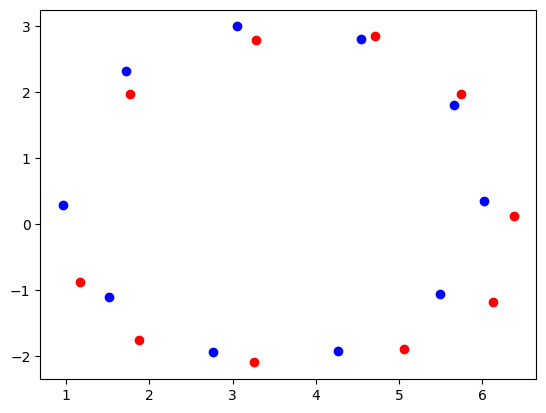

In [62]:
initial_state = np.array([[1.0, 1.0, 0.5]])
plotActualDynamicsAndNNPredictions(initial_state)

#### 6.2) For $x_0 = [5.0, 8.0, 1.5]$

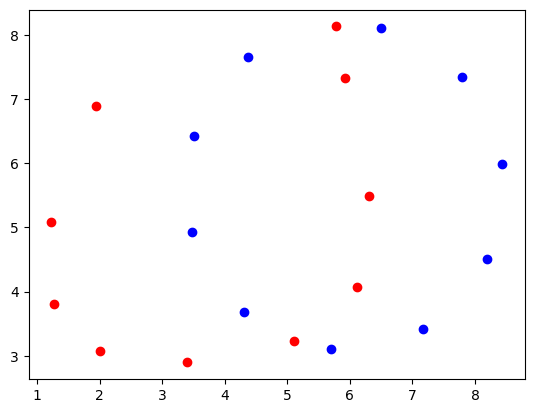

In [63]:
initial_state = np.array([[5.0, 8.0, 1.5]])
plotActualDynamicsAndNNPredictions(initial_state)

<span style="color: #8080ff">**QUESTION 5**: </span> Why does the NN predictions seem better for $x_0 = [1.0, 1.0, 0.5]$ compared with $x_0 = [5.0, 8.0, 1.5]$? (*Hint:* take a look at the file *DatasetGeneration.ipynb* to see how the trajectories are created for the dataset, in specific the initial points.)

**Answer:** Our dataset contains trajectories starting from the set $[-3, 3] \times [-3, 3] \times [-3, 3]$, and they tend to stay close to this set. Therefore, when we test our NN dynamics for $x_0 = [5.0, 8.0, 1.5]$, we are testing for a trajectory that is too far from the training set, and hence it is "natural" that results are worse. This can be seen as an example of a larger problem in ML called *distributional shift*.

In [58]:
print(g)

NameError: name 'g' is not defined

## Varying the hyperparamters
After seeing the example, we now have the goal of building a function which allows us to evaluate the performance for a certain implementation of a neural network, given a number of hyperparamters. The goal is to implement a neural network with two hidden layers, using relu activation in all but the last layers.

In [ ]:
def build_network(hidden_neurons_1, hidden_neurons_2):
    '''
    hidden_neurons_1: The amount of hidden neurons in the first hidden layer, int
    hidden_neurons_2: The amount of hidden neurons in the second hidden layer, int
    '''
    # Build the neural networ model class
    class Neural_network(nn.Module): 
        def __init__(self): 
            super(Neural_network, self).__init__()
            self.fc1 = nn.Linear(784, hidden_neurons_1, bias = True)  
            self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2, bias = True) 
            self.fc3 = nn.Linear(hidden_neurons_2, 10, bias = True) 

        def forward(self, x): 
            x = torch.flatten(x, start_dim = 1) 
            x = self.fc1(x) 
            x = F.relu(x) 
            x = self.fc2(x) 
            x = F.relu(x) 
            x = self.fc3(x) 
            x = F.softmax(x, dim = -1) 
            return x
        
    # Initialize the neural network
    torch.manual_seed(0)
    net = Neural_network()
    return net
    
def train_network(x_train_norm_short, x_test_norm,
                  y_train_cat_short, y_test, 
                  epochs, batch_size, 
                  net, optimizer):
    '''
    x_train_norm:     Normalized training data, np.array
    x_test_norm:      Normalized testing data, np.array
    y_train_cat:      One hot encoding of training labels, np.array
    y_test:           Testing labels, np.array
    epochs:           Number of epochs the model is trained for, int
    batch_size:       Batch size inside the epoch, int
    optimizer:        The optimizer used for training the neural network
    '''
    np.random.seed(0)
    # Define the neural network loss function
    loss_func = nn.MSELoss()
    
    # Train the neural network
    net.train() 
    batches = int(np.floor(len(y_train_cat)/batch_size)) 
    Index = np.arange(len(y_train_cat)) 
    for epoch in range(1, epochs + 1):
        np.random.shuffle(Index) 
        loss_epoch = 0
        for batch in range(batches):
            Index_batch = Index[batch * batch_size:(batch + 1) * batch_size]
            x_batch = torch.from_numpy(x_train_norm[Index_batch]) 
            y_batch = torch.from_numpy(y_train_cat[Index_batch].astype('float32')) 
            optimizer.zero_grad()
            y_batch_pred = net(x_batch)
            loss = loss_func(y_batch_pred, y_batch)
            loss.backward()
            optimizer.step()
            loss_epoch += loss
    
        loss_epoch /= batches
        print('Loss for epoch {}/{}: {:0.4e}'.format(epoch,epochs, loss_epoch) )
        
    # Predict test set
    net.eval()
    with torch.no_grad():
        y_test_pred = net(torch.from_numpy(x_test_norm))
    y_test_pred = y_test_pred.detach().numpy()
    
    # Exctract labels
    y_pred = y_test_pred.argmax(axis = 1)
    
    # Evaluate accuracy
    accuracy = np.mean(y_test == y_pred)
    
    return accuracy

After defining the function, we can now vary the hyperparameters. Here the goal is to vary two of the hyperparameters:
<ul>
  <li>The optimizer used: Use Adam as well as SDG</li>
  <li>The batch size used: Use 10, 100, 1000, 10000 </li>
  <li>The hidden_neurons_2 used: Use 10, 50, 100 </li>
</ul>  
Meanwhile, epochs = 100 and hidden_neurons_1 = 100 are to be used.

In [ ]:
Optimizers = ['sdg', 'adam'] #, optimizer_adam]
Batch_size = [10, 100, 1000, 10000]
Hidden_neurons_2 = [10, 50, 100]

epochs = 100
hidden_neurons_1 = 100

Accuracy = np.zeros((len(Optimizers), len(Batch_size), len(Hidden_neurons_2)))

# For faster computation, we will use less data_samples
Index = np.arange(len(y_train))
np.random.shuffle(Index)
num_train_samples = 60000
x_train_norm_short = x_train_norm[Index[:num_train_samples]]
y_train_cat_short = y_train_cat[Index[:num_train_samples]]


for i, opti in enumerate(Optimizers):
    for j, batch_size in enumerate(Batch_size):
        for k, hidden_neurons_2 in enumerate(Hidden_neurons_2):
            net = build_network(hidden_neurons_1, hidden_neurons_2)
            
            if opti == 'sdg':
                optimizer = optim.SGD(net.parameters(), lr=0.001)
            else:
                optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
                
            accuracy = train_network(x_train_norm_short, x_test_norm,  
                                     y_train_cat_short, y_test, 
                                     epochs, batch_size, 
                                     net, optimizer)
        
            Accuracy[i,j,k] = accuracy

NameError: name 'x_train_norm' is not defined

In [ ]:
print(Accuracy)

[[[0.3407 0.3407 0.3407]
  [0.1307 0.1307 0.1307]
  [0.0979 0.0979 0.0979]]

 [[0.9748 0.9748 0.9748]
  [0.9744 0.9744 0.9744]
  [0.9706 0.9706 0.9706]]]
